In [1]:
import pandas as pd
import numpy as np
from collections import OrderedDict, namedtuple
from tqdm import tqdm
from datetime import date
from sklearn.metrics import log_loss, roc_auc_score, auc, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import gc
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

data_offline = pd.read_csv('../data/ccf_offline_stage1_train.csv')
data_online = pd.read_csv('../data/ccf_online_stage1_train.csv')
test = pd.read_csv('../data/ccf_offline_stage1_test_revised.csv')


data_offline.fillna('null', inplace=True)
data_online.fillna('null', inplace=True)
test = test.fillna('null')
data_offline['Date_received'] = data_offline['Date_received'].astype(str)
data_online['Date_received'] = data_online['Date_received'].astype(str)
data_offline['Date'] = data_offline['Date'].astype(str)
test['Date_received'] = test['Date_received'].astype(str)


# convert Discount_rate and Distance

def getDiscountType(row):
    if row == 'null':
        return 'null'
    elif ':' in row:
        return 1
    else:
        return 0

def convertRate(row):
    """Convert discount to rate"""
    if row == 'null':
        return 1.0
    elif ':' in row:
        rows = row.split(':')
        return 1.0 - float(rows[1])/float(rows[0])
    else:
        return float(row)

def getDiscountMan(row):
    if ':' in row:
        rows = row.split(':')
        return int(rows[0])
    else:
        return 0

def getDiscountJian(row):
    if ':' in row:
        rows = row.split(':')
        return int(rows[1])
    else:
        return 0

def processData(df):

    # convert discunt_rate
    df['discount_rate'] = df['Discount_rate'].apply(convertRate)
    df['discount_man'] = df['Discount_rate'].apply(getDiscountMan)
    df['discount_jian'] = df['Discount_rate'].apply(getDiscountJian)
    df['discount_type'] = df['Discount_rate'].apply(getDiscountType)
    # convert distance
    df['distance'] = df['Distance'].replace('null', -1).astype(int)
    return df

data_offline = processData(data_offline)
test = processData(test)

def getWeekday(row):
    if row == 'null':
        return row
    else:
        return date(int(row[0:4]), int(row[4:6]), int(row[6:8])).weekday() + 1

def getDay(row):
    if row == 'null':
        return row
    else:
        return date(int(row[0:4]), int(row[4:6]), int(row[6:8])).day

data_offline['weekday'] = data_offline['Date_received'].astype(str).apply(getWeekday)
test['weekday'] = test['Date_received'].astype(str).apply(getWeekday)
data_offline['day'] = data_offline['Date_received'].astype(str).apply(getDay)
test['day'] = test['Date_received'].astype(str).apply(getDay)

# weekday_type :  周六和周日为1，其他为0
data_offline['weekday_type'] = data_offline['weekday'].apply(lambda x : 1 if x in [6,7] else 0 )
test['weekday_type'] = test['weekday'].apply(lambda x : 1 if x in [6,7] else 0 )
def label(row):
    if row['Date_received'] == 'null':
        return -1
    if row['Date'] != 'null':
        td = pd.to_datetime(row['Date'], format='%Y%m%d') -  pd.to_datetime(row['Date_received'], format='%Y%m%d')
        if td <= pd.Timedelta(15, 'D'):
            return 1
    return 0
data_offline['label'] = data_offline.apply(label, axis=1)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.barplot(x=data_offline[data_offline.label != -1]['label'].value_counts().index,y=data_offline[data_offline.label != -1]['label'].value_counts().values)
# feature 表示处于20190516号之前的数据做为用户的历史特征。
feature = data_offline[(data_offline['Date'] < '20160516') | ((data_offline['Date'] == 'null') & (data_offline['Date_received'] < '20160516'))].copy()
# dataset 表示处于20160516～20160615之间的数据做为训练样本和测试样本。
dataset = data_offline[(data_offline['Date_received'] >= '20160516') & (data_offline['Date_received'] <= '20160615')].copy()

# 用户聚合特征
fdf = feature.copy()
# key of user
u = fdf[['User_id']].copy().drop_duplicates()
# u_coupon_count : num of coupon received by user
u1 = fdf[fdf['Date_received'] != 'null'][['User_id']].copy()
u1['u_coupon_count'] = 1
u1 = u1.groupby(['User_id'], as_index = False).count()
# u_buy_count : times of user buy offline (with or without coupon)
u2 = fdf[fdf['Date'] != 'null'][['User_id']].copy()
u2['u_buy_count'] = 1
u2 = u2.groupby(['User_id'], as_index = False).count()
# u_buy_with_coupon : times of user buy offline (with coupon)
u3 = fdf[((fdf['Date'] != 'null') & (fdf['Date_received'] != 'null'))][['User_id']].copy()
u3['u_buy_with_coupon'] = 1
u3 = u3.groupby(['User_id'], as_index = False).count()
# u_merchant_count : num of merchant user bought from
u4 = fdf[fdf['Date'] != 'null'][['User_id', 'Merchant_id']].copy()
u4.drop_duplicates(inplace = True)
u4 = u4.groupby(['User_id'], as_index = False).count()
u4.rename(columns = {'Merchant_id':'u_merchant_count'}, inplace = True)
# u_min_distance，u_max_distance，u_mean_distance，u_median_distance
utmp = fdf[(fdf['Date'] != 'null') & (fdf['Date_received'] != 'null')][['User_id', 'distance']].copy()
utmp.replace(-1, np.nan, inplace = True)
u5 = utmp.groupby(['User_id'], as_index = False).min()
u5.rename(columns = {'distance':'u_min_distance'}, inplace = True)
u6 = utmp.groupby(['User_id'], as_index = False).max()
u6.rename(columns = {'distance':'u_max_distance'}, inplace = True)
u7 = utmp.groupby(['User_id'], as_index = False).mean()
u7.rename(columns = {'distance':'u_mean_distance'}, inplace = True)
u8 = utmp.groupby(['User_id'], as_index = False).median()
u8.rename(columns = {'distance':'u_median_distance'}, inplace = True)
# merge all the features on key User_id
user_feature = pd.merge(u, u1, on = 'User_id', how = 'left')
user_feature = pd.merge(user_feature, u2, on = 'User_id', how = 'left')
user_feature = pd.merge(user_feature, u3, on = 'User_id', how = 'left')
user_feature = pd.merge(user_feature, u4, on = 'User_id', how = 'left')
user_feature = pd.merge(user_feature, u5, on = 'User_id', how = 'left')
user_feature = pd.merge(user_feature, u6, on = 'User_id', how = 'left')
user_feature = pd.merge(user_feature, u7, on = 'User_id', how = 'left')
user_feature = pd.merge(user_feature, u8, on = 'User_id', how = 'left')
# calculate rate
user_feature['u_use_coupon_rate'] = user_feature['u_buy_with_coupon'].astype('float')/user_feature['u_coupon_count'].astype('float')
user_feature['u_buy_with_coupon_rate'] = user_feature['u_buy_with_coupon'].astype('float')/user_feature['u_buy_count'].astype('float')
user_feature = user_feature.fillna(0)
# add user feature to dataset on key User_id
dataset2 = pd.merge(dataset, user_feature, on = 'User_id', how = 'left').fillna(0)

del u, u1, u2, u3, u4, u5, u6, u7, u8, utmp, user_feature
gc.collect()

# 商户聚合特征
# key of merchant
m = fdf[['Merchant_id']].copy().drop_duplicates()
# m_coupon_count : num of coupon from merchant
m1 = fdf[fdf['Date_received'] != 'null'][['Merchant_id']].copy()
m1['m_coupon_count'] = 1
m1 = m1.groupby(['Merchant_id'], as_index = False).count()
# m_sale_count : num of sale from merchant (with or without coupon)
m2 = fdf[fdf['Date'] != 'null'][['Merchant_id']].copy()
m2['m_sale_count'] = 1
m2 = m2.groupby(['Merchant_id'], as_index = False).count()
# m_sale_with_coupon : num of sale from merchant with coupon usage
m3 = fdf[(fdf['Date'] != 'null') & (fdf['Date_received'] != 'null')][['Merchant_id']].copy()
m3['m_sale_with_coupon'] = 1
m3 = m3.groupby(['Merchant_id'], as_index = False).count()
# m_min_distance，m_max_distance，m_mean_distance，m_median_distance
mtmp = fdf[(fdf['Date'] != 'null') & (fdf['Date_received'] != 'null')][['Merchant_id', 'distance']].copy()
mtmp.replace(-1, np.nan, inplace = True)
m4 = mtmp.groupby(['Merchant_id'], as_index = False).min()
m4.rename(columns = {'distance':'m_min_distance'}, inplace = True)
m5 = mtmp.groupby(['Merchant_id'], as_index = False).max()
m5.rename(columns = {'distance':'m_max_distance'}, inplace = True)
m6 = mtmp.groupby(['Merchant_id'], as_index = False).mean()
m6.rename(columns = {'distance':'m_mean_distance'}, inplace = True)
m7 = mtmp.groupby(['Merchant_id'], as_index = False).median()
m7.rename(columns = {'distance':'m_median_distance'}, inplace = True)
merchant_feature = pd.merge(m, m1, on = 'Merchant_id', how = 'left')
merchant_feature = pd.merge(merchant_feature, m2, on = 'Merchant_id', how = 'left')
merchant_feature = pd.merge(merchant_feature, m3, on = 'Merchant_id', how = 'left')
merchant_feature = pd.merge(merchant_feature, m4, on = 'Merchant_id', how = 'left')
merchant_feature = pd.merge(merchant_feature, m5, on = 'Merchant_id', how = 'left')
merchant_feature = pd.merge(merchant_feature, m6, on = 'Merchant_id', how = 'left')
merchant_feature = pd.merge(merchant_feature, m7, on = 'Merchant_id', how = 'left')
merchant_feature = merchant_feature.fillna(0)
merchant_feature['m_coupon_use_rate'] = merchant_feature['m_sale_with_coupon'].astype('float')/merchant_feature['m_coupon_count'].astype('float')
merchant_feature['m_sale_with_coupon_rate'] = merchant_feature['m_sale_with_coupon'].astype('float')/merchant_feature['m_sale_count'].astype('float')
merchant_feature = merchant_feature.fillna(0)
# add merchant feature to dataset2
dataset3 = pd.merge(dataset2, merchant_feature, on = 'Merchant_id', how = 'left').fillna(0)

del m, m1, m2, m3, m4, m5, m6, m7, mtmp, merchant_feature
gc.collect()

# 用户&商户聚合特征
# key of user and merchant
um = fdf[['User_id', 'Merchant_id']].copy().drop_duplicates()
um1 = fdf[['User_id', 'Merchant_id']].copy()
um1['um_count'] = 1
um1 = um1.groupby(['User_id', 'Merchant_id'], as_index = False).count()
um2 = fdf[fdf['Date'] != 'null'][['User_id', 'Merchant_id']].copy()
um2['um_buy_count'] = 1
um2 = um2.groupby(['User_id', 'Merchant_id'], as_index = False).count()
um3 = fdf[fdf['Date_received'] != 'null'][['User_id', 'Merchant_id']].copy()
um3['um_coupon_count'] = 1
um3 = um3.groupby(['User_id', 'Merchant_id'], as_index = False).count()
um4 = fdf[(fdf['Date_received'] != 'null') & (fdf['Date'] != 'null')][['User_id', 'Merchant_id']].copy()
um4['um_buy_with_coupon'] = 1
um4 = um4.groupby(['User_id', 'Merchant_id'], as_index = False).count()
# merge all user merchant
user_merchant_feature = pd.merge(um, um1, on = ['User_id','Merchant_id'], how = 'left')
user_merchant_feature = pd.merge(user_merchant_feature, um2, on = ['User_id','Merchant_id'], how = 'left')
user_merchant_feature = pd.merge(user_merchant_feature, um3, on = ['User_id','Merchant_id'], how = 'left')
user_merchant_feature = pd.merge(user_merchant_feature, um4, on = ['User_id','Merchant_id'], how = 'left')
user_merchant_feature = user_merchant_feature.fillna(0)
user_merchant_feature['um_buy_rate'] = user_merchant_feature['um_buy_count'].astype('float')/user_merchant_feature['um_count'].astype('float')
user_merchant_feature['um_coupon_use_rate'] = user_merchant_feature['um_buy_with_coupon'].astype('float')/user_merchant_feature['um_coupon_count'].astype('float')
user_merchant_feature['um_buy_with_coupon_rate'] = user_merchant_feature['um_buy_with_coupon'].astype('float')/user_merchant_feature['um_buy_count'].astype('float')
user_merchant_feature = user_merchant_feature.fillna(0)
# add user_merchant_feature to data3
dataset4 = pd.merge(dataset3, user_merchant_feature, on = ['User_id','Merchant_id'], how = 'left').fillna(0)

del um, um1, um2, um3, um4, user_merchant_feature
gc.collect()


def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in tqdm(df.columns):
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

class SingleFeat(namedtuple('SingleFeat', ['name', 'dimension', 'dtype'])):
    __slots__ = ()

    def __new__(cls, name, dimension, dtype="float32"):
        return super(SingleFeat, cls).__new__(cls, name, dimension, dtype)

dataset4 = reduce_mem_usage(dataset4)
# 定义sparse feature和dense feature
sparse_features = ['User_id', 'Merchant_id', 'Coupon_id', 'weekday', 'discount_type', 'weekday_type']
dense_features = [fea for fea in dataset4.columns if fea not in sparse_features and fea not in ['Discount_rate', 'Distance', 'Date_received', 'Date', 'label']]

dataset4[sparse_features] = dataset4[sparse_features].fillna('null', )
dataset4[dense_features] = dataset4[dense_features].fillna(0, )



log_features = ['u_coupon_count', 'u_buy_count','u_buy_with_coupon', 'u_merchant_count', 'u_min_distance',
       'u_max_distance', 'u_mean_distance', 'u_median_distance',
       'u_use_coupon_rate', 'u_buy_with_coupon_rate', 'm_coupon_count',
       'm_sale_count', 'm_sale_with_coupon', 'm_min_distance',
       'm_max_distance', 'm_mean_distance', 'm_median_distance',
       'm_coupon_use_rate', 'm_sale_with_coupon_rate', 'um_count',
       'um_buy_count', 'um_coupon_count', 'um_buy_with_coupon', 'um_buy_rate',
       'um_coupon_use_rate', 'um_buy_with_coupon_rate']

for fea in tqdm(log_features):
    dataset4[fea] = dataset4[fea].apply(lambda x: np.log1p(x))

for feat in tqdm(sparse_features):
    lbe = LabelEncoder()
    dataset4[feat] = lbe.fit_transform(dataset4[feat])
mms = MinMaxScaler(feature_range=(0, 1))
dataset4[dense_features] = mms.fit_transform(dataset4[dense_features])

sparse_feature_list = [SingleFeat(feat, dataset4[feat].nunique()) for feat in sparse_features]
dense_feature_list = [SingleFeat(feat, 0,) for feat in dense_features]
train, valid = train_test_split(dataset4, test_size=0.2, stratify=dataset4['label'], random_state=2019)
train_model_input = [train[feat.name].values for feat in sparse_feature_list] + \
                    [train[feat.name].values for feat in dense_feature_list]
valid_model_input = [valid[feat.name].values for feat in sparse_feature_list] + \
                   [valid[feat.name].values for feat in dense_feature_list]
checkpoint_predictions = []
weights = []




  0%|          | 0/26 [00:00<?, ?it/s]

Mem. usage decreased to 26.37 Mb (67.7% reduction)


100%|██████████| 6/6 [00:00<00:00, 71.38it/s]


In [2]:
train_xgb = [train[feat.name].values for feat in dense_feature_list]
valid_xgb = [valid[feat.name].values for feat in dense_feature_list]

train_xgb = np.transpose(train_xgb)
valid_xgb = np.transpose(valid_xgb)

train_label_xgb = train['label'].values
valid_label_xgb = valid['label'].values

train_xgb = np.array(train_xgb)
valid_xgb = np.array(valid_xgb)

In [3]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(max_depth=8, 
                              learning_rate=0.1, 
                              n_estimators=200, 
                              objective="binary:logistic", 
                              booster='gbtree'
                              )

xgb_model.fit(train_xgb, train_label_xgb)



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [4]:
score = xgb_model.score(valid_xgb, valid_label_xgb)

print(score)

0.920337996507637


In [5]:
from sklearn.metrics import log_loss, roc_auc_score, auc, roc_curve
pred = xgb_model.predict_proba(valid_xgb)
pred = [p[1] for p in pred]

In [6]:
np.shape(train_model_input)

# pred

(37, 199288)

In [7]:
auc_score = roc_auc_score(valid_label_xgb, np.array(pred))
print(auc_score)

0.8588603111312081


In [8]:
[feat.name for feat in dense_feature_list]


['discount_rate',
 'discount_man',
 'discount_jian',
 'distance',
 'day',
 'u_coupon_count',
 'u_buy_count',
 'u_buy_with_coupon',
 'u_merchant_count',
 'u_min_distance',
 'u_max_distance',
 'u_mean_distance',
 'u_median_distance',
 'u_use_coupon_rate',
 'u_buy_with_coupon_rate',
 'm_coupon_count',
 'm_sale_count',
 'm_sale_with_coupon',
 'm_min_distance',
 'm_max_distance',
 'm_mean_distance',
 'm_median_distance',
 'm_coupon_use_rate',
 'm_sale_with_coupon_rate',
 'um_count',
 'um_buy_count',
 'um_coupon_count',
 'um_buy_with_coupon',
 'um_buy_rate',
 'um_coupon_use_rate',
 'um_buy_with_coupon_rate']

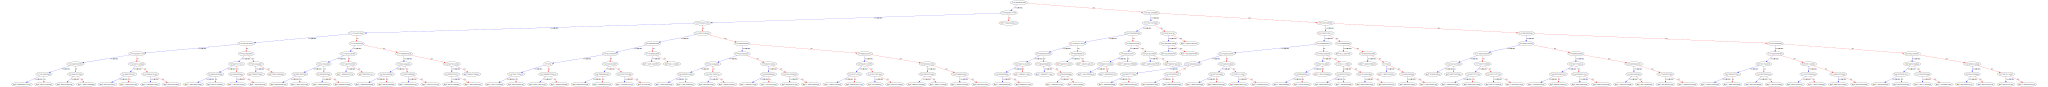

In [15]:
xgb.to_graphviz(xgb_model, num_trees=199)


In [10]:
xgb_model.feature_importances_

array([0.04136316, 0.04523034, 0.04890164, 0.01800824, 0.01504889,
       0.01036597, 0.01236738, 0.01008068, 0.01126429, 0.01100151,
       0.00902154, 0.01156646, 0.01536176, 0.01514965, 0.01340825,
       0.04642476, 0.03458873, 0.03274173, 0.01659093, 0.0152928 ,
       0.02051054, 0.02104059, 0.05896797, 0.02556358, 0.01536238,
       0.19105196, 0.01430003, 0.01620072, 0.07159399, 0.12017194,
       0.01145751], dtype=float32)

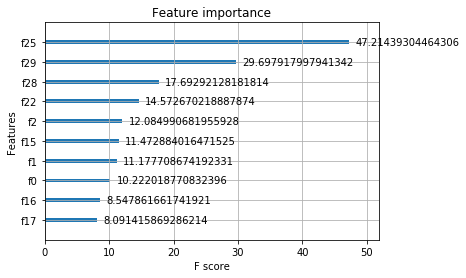

In [11]:
xgb.plot_importance(xgb_model,max_num_features=10,importance_type='gain')

In [12]:
im=pd.DataFrame({'importance':xgb_model.feature_importances_,'var':[feat.name for feat in dense_feature_list]})
im=im.sort_values(by='importance',ascending=False)
im.head(10)



,importance,var
25,0.191052,um_buy_count
29,0.120172,um_coupon_use_rate
28,0.071594,um_buy_rate
22,0.058968,m_coupon_use_rate
2,0.048902,discount_jian
15,0.046425,m_coupon_count
1,0.045230,discount_man
0,0.041363,discount_rate
16,0.034589,m_sale_count
17,0.032742,m_sale_with_coupon


In [13]:
xgb_model.get_score(fmap=model_dir + fmap_file, importance_type='weight')

AttributeError: 'XGBClassifier' object has no attribute 'get_score'